# Generative Adversarial Networks: From Theory to Implementation 🎨

Welcome to this tutorial on **Generative Adversarial Networks (GANs)**! This notebook will guide you through understanding, building, and training GANs from the ground up.

We will start by building a simple GAN using fully-connected layers (MLPs) and then upgrade to a much more powerful **Deep Convolutional GAN (DCGAN)**.

## What is a Generative Model?

Before diving into GANs, let's understand their category. Most models you may have used (like classifiers) are **discriminative**. They learn to *separate* data into classes (e.g., "is this image a '3' or a '7'?").

**Generative models** are different. Their goal is to *create* new, synthetic data that looks like it came from the real dataset. Instead of learning a boundary *between* classes, they learn the underlying *distribution* of the data itself.

## 1. Introduction to GANs <a id='introduction'></a>

### The Core Concept: A Game-Theoretic Approach

A GAN, introduced by Ian Goodfellow in 2014, is a clever type of generative model. The core idea is based on a **zero-sum game** between two competing neural networks:

**1. The Generator (G) 🧑‍🎨**
- **Role**: Creates synthetic data that mimics the real data distribution
- **Input**: Random noise vector **z** sampled from a latent space (typically Gaussian)
- **Output**: Synthetic data **G(z)** that should be indistinguishable from real data
- **Objective**: Fool the Discriminator into classifying fake samples as real

**2. The Discriminator (D) 🧐**
- **Role**: Distinguishes between real and generated samples
- **Input**: Either real data **x** or generated data **G(z)**
- **Output**: Probability that the input is real (value between 0 and 1)
- **Objective**: Correctly classify real samples as real and fake samples as fake

### The Adversarial Training Process

The two networks are trained simultaneously in opposition:
- The **Discriminator** learns to better distinguish real from fake
- The **Generator** learns to produce more realistic samples
- This creates a feedback loop that pushes both networks to improve

**Equilibrium**: Ideally, training converges to a Nash equilibrium where:
- The Generator produces perfect samples: **G(z) ~ p_data(x)**
- The Discriminator cannot tell the difference: **D(x) = D(G(z)) = 0.5**

### Why GANs Matter

- **High-quality generation**: GANs produce sharper, more realistic samples compared to earlier generative models
- **Unsupervised learning**: Learn complex data distributions without explicit labels
- **Versatile applications**: Image synthesis, style transfer, data augmentation, super-resolution, and more

---

## 2. Mathematical Foundations <a id='math-foundations'></a>

### The GAN Objective Function: A Minimax Game

The GAN training objective is formulated as a minimax game:

$$\min_G \max_D V(D,G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

Let's break this down:

**First Term: $\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)]$**
- Expected log probability that the Discriminator correctly identifies real samples
- The Discriminator wants to **maximize** this (make D(x) close to 1)

**Second Term: $\mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$**
- Expected log probability that the Discriminator correctly identifies fake samples
- The Discriminator wants to **maximize** this (make D(G(z)) close to 0)
- The Generator wants to **minimize** this (make D(G(z)) close to 1)

### Training Steps in Detail

**Step 1: Train the Discriminator**
- Sample a minibatch of real data: $\{x^{(1)}, ..., x^{(m)}\}$
- Sample a minibatch of noise: $\{z^{(1)}, ..., z^{(m)}\}$
- Generate fake samples: $\{G(z^{(1)}), ..., G(z^{(m)})\}$
- Update D by ascending its stochastic gradient:

$$\nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^{m}[\log D(x^{(i)}) + \log(1 - D(G(z^{(i)})))]$$

**Step 2: Train the Generator**
- Sample a minibatch of noise: $\{z^{(1)}, ..., z^{(m)}\}$
- Update G by descending its stochastic gradient:

$$\nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^{m}\log(1 - D(G(z^{(i)})))$$

**Note**: In practice, we often use the alternative generator loss: $-\log D(G(z))$ instead of $\log(1 - D(G(z)))$ because it provides stronger gradients early in training.

### Challenges in GAN Training

1. **Mode Collapse**: Generator produces limited variety of samples
2. **Vanishing Gradients**: Discriminator becomes too strong, providing no useful gradient to the Generator
3. **Training Instability**: Difficulty in balancing the two networks
4. **Lack of Convergence**: No guarantee of reaching equilibrium

---

## 3. Vanilla GAN Implementation <a id='vanilla-gan'></a>

Let's implement a basic GAN using fully connected layers on the MNIST dataset. This "vanilla" GAN will help us understand the core mechanics before moving to more advanced architectures.

### 3.1 Setup and Dependencies

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [39]:
# Configure device and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
lr = 2e-4              # Learning rate - lower rates often work better for GANs
batch_size = 128       # Number of samples per batch
image_size = 28 * 28   # Flattened MNIST image size (784)
z_dim = 100            # Dimensionality of latent noise vector
num_epochs = 50        # Number of training epochs

Using device: cuda


#### What is the Latent Dimension (`z_dim`)?

The `z_dim` (e.g., 100) is the size of the random noise vector we pass to the Generator. This vector is sampled from a simple distribution (like a Gaussian). This is the **latent space**.

Think of it as a control panel for the Generator. By learning to map different points from this simple 100-dimensional space to the complex 784-dimensional space of images, the Generator learns a *compressed representation* of the data. Changing the input noise vector results in a different generated image.

### 3.2 Data Preparation

**Key Preprocessing Steps:**
- Convert images to PyTorch tensors
- Normalize pixel values from [0, 255] to [-1, 1]

**Why normalize to [-1, 1]?**
- The Generator uses `tanh` activation which outputs in range [-1, 1]
- Matching the data range to the generator output range improves training stability
- The formula: `normalized = (pixel / 255.0 - 0.5) / 0.5 = (pixel - 127.5) / 127.5`

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),                    # Convert PIL Image to tensor [0, 1]
    transforms.Normalize((0.5,), (0.5,)),     # Normalize to [-1, 1]
])

# Load MNIST dataset
dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Dataset loaded: {len(dataset)} training images")
print(f"Number of batches per epoch: {len(loader)}")

Dataset loaded: 60000 training images
Number of batches per epoch: 469


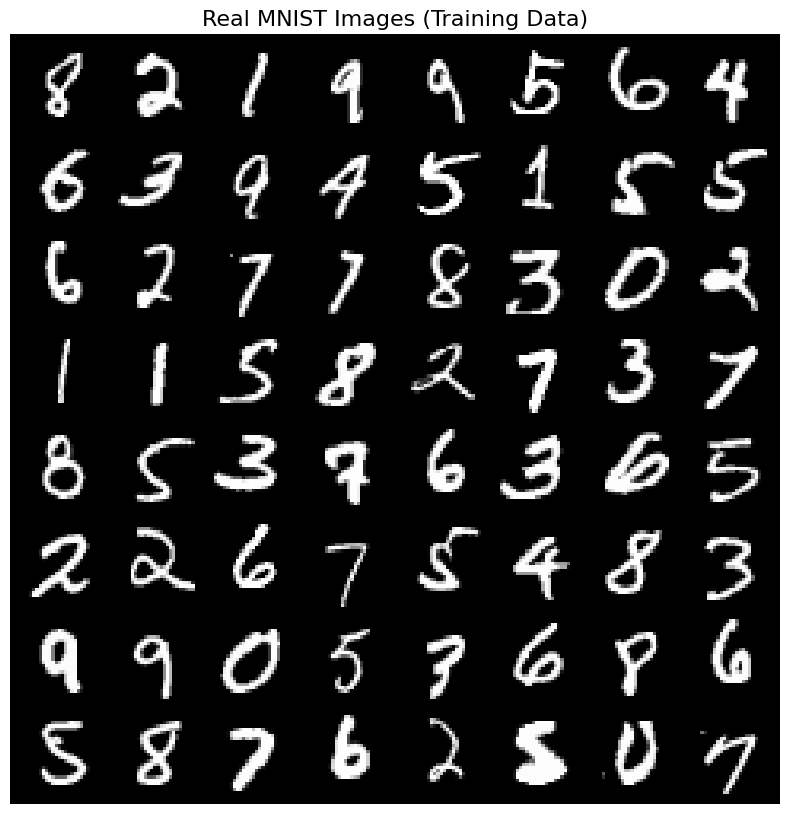

Batch shape: torch.Size([128, 1, 28, 28])
Value range: [-1.00, 1.00]


In [43]:
# Visualize sample real images
real_batch = next(iter(loader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Real MNIST Images (Training Data)", fontsize=16)
grid = torchvision.utils.make_grid(real_batch[0][:64], padding=2, normalize=True, nrow=8)
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.show()

print(f"Batch shape: {real_batch[0].shape}")  # [batch_size, channels, height, width]
print(f"Value range: [{real_batch[0].min():.2f}, {real_batch[0].max():.2f}]")

### 3.3 Network Architectures

We'll define simple multi-layer perceptron (MLP) architectures for both networks.

#### The Discriminator Network (The Critic 🧐)

**Architecture Details:**
- **Input**: Flattened image (784 dimensions)
- **Hidden Layer**: 128 units with LeakyReLU activation
- **Output**: Single logit (raw score, not probability)

**Design Choices:**
- **LeakyReLU**: Allows small negative gradients (slope = 0.1) which helps prevent dying neurons and improves gradient flow
- **No sigmoid**: We use `BCEWithLogitsLoss` which combines sigmoid and BCE loss for numerical stability
- **Simple architecture**: Sufficient for MNIST, more complex data requires deeper networks

In [46]:
class Discriminator(nn.Module):
    """Binary classifier that distinguishes real from fake images."""

    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            # Note: No sigmoid here - BCEWithLogitsLoss applies it internally
        )

    def forward(self, x):
        return self.disc(x)

# Test the discriminator
test_disc = Discriminator(image_size)
test_input = torch.randn(batch_size, image_size)
test_output = test_disc(test_input)
print(f"Discriminator output shape: {test_output.shape}")  # Should be [batch_size, 1]
print(f"Number of parameters: {sum(p.numel() for p in test_disc.parameters())}")

Discriminator output shape: torch.Size([128, 1])
Number of parameters: 100609


#### The Generator Network (The Forger 🧑‍🎨)

**Architecture Details:**
- **Input**: Random noise vector (100 dimensions)
- **Hidden Layer**: 256 units with LeakyReLU activation
- **Output**: Flattened image (784 dimensions) with tanh activation

**Design Choices:**
- **Larger hidden layer**: Generator typically needs more capacity than discriminator
- **tanh activation**: Ensures output is in [-1, 1] matching our normalized data
- **Noise dimension**: 100 is a common choice providing sufficient variation

In [9]:
class Generator(nn.Module):
    """Generates fake images from random noise vectors."""

    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # Output range: [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

# Test the generator
test_gen = Generator(z_dim, image_size)
test_noise = torch.randn(batch_size, z_dim)
test_fake = test_gen(test_noise)
print(f"Generator output shape: {test_fake.shape}")  # Should be [batch_size, 784]
print(f"Output value range: [{test_fake.min():.2f}, {test_fake.max():.2f}]")
print(f"Number of parameters: {sum(p.numel() for p in test_gen.parameters())}")

Generator output shape: torch.Size([128, 784])
Output value range: [-0.80, 0.82]
Number of parameters: 227344


### 3.4 Initialize Training Components

In [10]:
# Initialize networks
disc = Discriminator(image_size).to(device)
gen = Generator(z_dim, image_size).to(device)

# Fixed noise for consistent visualization across epochs
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

# Optimizers - Adam with beta1=0.5 is common for GANs
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function - BCE with logits is more numerically stable
criterion = nn.BCEWithLogitsLoss()

print("Training components initialized successfully!")
print(f"Total parameters - Generator: {sum(p.numel() for p in gen.parameters())}")
print(f"Total parameters - Discriminator: {sum(p.numel() for p in disc.parameters())}")

Training components initialized successfully!
Total parameters - Generator: 227344
Total parameters - Discriminator: 100609


### 3.5 Training Loop

**Training the Discriminator:**
1.  Get a batch of real images from `loader`. We label these as `1` (real).
2.  Generate a batch of fake images using `gen(noise)`. We label these as `0` (fake).
3.  Calculate the Discriminator's loss on both real and fake batches.
4.  Update the Discriminator's weights (`opt_disc.step()`).

**Training the Generator:**
1.  Generate a batch of fake images.
2.  Try to fool the Discriminator by **labeling them as `1`** (real). This is the non-saturating loss trick.
3.  Calculate the Generator's loss based on the Discriminator's (fooled) output.
4.  Update the Generator's weights (`opt_gen.step()`).

**Important Implementation Details:**
- Use `.detach()` on fake images when training discriminator to avoid backpropagating through generator
- Alternative generator loss: maximize log(D(G(z))) instead of minimizing log(1 - D(G(z))) for better gradients

In [11]:
# Training history
generator_losses = []
discriminator_losses = []
img_list = []

print("Starting Training...\n" + "="*50)

for epoch in range(num_epochs):
    epoch_g_loss = 0
    epoch_d_loss = 0

    for batch_idx, (real, _) in enumerate(loader):
        # Flatten images and move to device
        real = real.view(-1, image_size).to(device)
        batch_size_current = real.shape[0]

        # ===========================
        # Train Discriminator
        # Goal: Maximize log(D(x)) + log(1 - D(G(z)))
        # ===========================

        disc.zero_grad()

        # Train on real images
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        # Train on fake images
        noise = torch.randn(batch_size_current, z_dim).to(device)
        fake = gen(noise)
        disc_fake = disc(fake.detach()).view(-1)  # detach() prevents gradient flow to generator
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        # Combine losses and backpropagate
        lossD = (lossD_real + lossD_fake) / 2
        lossD.backward()
        opt_disc.step()

        # ===========================
        # Train Generator
        # Goal: Maximize log(D(G(z))) or minimize log(1 - D(G(z)))
        # ===========================

        gen.zero_grad()

        # Generate fake images and get discriminator's opinion
        output = disc(fake).view(-1)  # Use same fake batch (no detach this time)
        lossG = criterion(output, torch.ones_like(output))  # Want discriminator to think they're real
        lossG.backward()
        opt_gen.step()

        # Accumulate losses
        epoch_g_loss += lossG.item()
        epoch_d_loss += lossD.item()

        # Print progress
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(loader)}] "
                  f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

    # Store average epoch losses
    avg_g_loss = epoch_g_loss / len(loader)
    avg_d_loss = epoch_d_loss / len(loader)
    generator_losses.append(avg_g_loss)
    discriminator_losses.append(avg_d_loss)

    # Generate samples with fixed noise for visualization
    with torch.no_grad():
        fake_images = gen(fixed_noise).reshape(-1, 1, 28, 28)
        img_grid = torchvision.utils.make_grid(fake_images[:32], normalize=True, nrow=8)
        img_list.append(img_grid)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] completed - Avg Loss D: {avg_d_loss:.4f}, Avg Loss G: {avg_g_loss:.4f}\n")

print("="*50)
print("Training completed!")

Starting Training...
Epoch [1/50] Batch [0/469] Loss D: 0.6605, Loss G: 0.6759
Epoch [1/50] Batch [100/469] Loss D: 0.6037, Loss G: 0.5451
Epoch [1/50] Batch [200/469] Loss D: 0.6553, Loss G: 0.5806
Epoch [1/50] Batch [300/469] Loss D: 0.6494, Loss G: 0.6498
Epoch [1/50] Batch [400/469] Loss D: 0.6173, Loss G: 0.7217

Epoch [1/50] completed - Avg Loss D: 0.6044, Avg Loss G: 0.6370

Epoch [2/50] Batch [0/469] Loss D: 0.5653, Loss G: 0.7862
Epoch [2/50] Batch [100/469] Loss D: 0.5575, Loss G: 0.8172
Epoch [2/50] Batch [200/469] Loss D: 0.6004, Loss G: 0.8000
Epoch [2/50] Batch [300/469] Loss D: 0.6221, Loss G: 0.7826
Epoch [2/50] Batch [400/469] Loss D: 0.6169, Loss G: 0.7973

Epoch [2/50] completed - Avg Loss D: 0.6038, Avg Loss G: 0.7796

Epoch [3/50] Batch [0/469] Loss D: 0.6100, Loss G: 0.7732
Epoch [3/50] Batch [100/469] Loss D: 0.5667, Loss G: 0.8508
Epoch [3/50] Batch [200/469] Loss D: 0.5902, Loss G: 0.8446
Epoch [3/50] Batch [300/469] Loss D: 0.6193, Loss G: 0.8140
Epoch [3/50] 

### 3.6 Results and Analysis

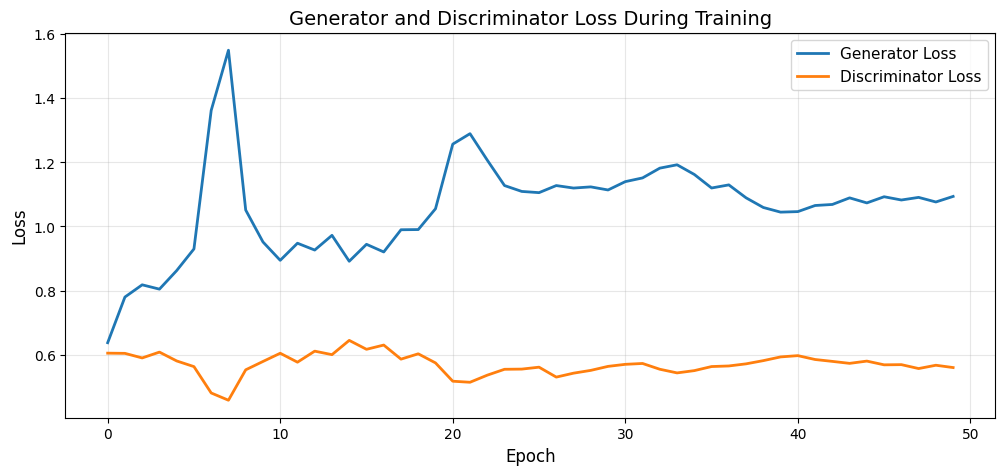


Loss Analysis:
Final Generator Loss: 1.0938
Final Discriminator Loss: 0.5594

Ideal scenario: Both losses should stabilize around 0.693 (log(2))


In [12]:
# Plot training losses
plt.figure(figsize=(12, 5))
plt.title("Generator and Discriminator Loss During Training", fontsize=14)
plt.plot(generator_losses, label="Generator Loss", linewidth=2)
plt.plot(discriminator_losses, label="Discriminator Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("\nLoss Analysis:")
print(f"Final Generator Loss: {generator_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {discriminator_losses[-1]:.4f}")
print("\nIdeal scenario: Both losses should stabilize around 0.693 (log(2))")

#### How to Read the Loss Plot

Unlike a normal supervised learning problem, you don't want the losses to go to zero. The GAN is in a constant battle.

* **`Loss D` (Discriminator):** If this goes to 0, the discriminator is perfectly identifying fakes, and the generator isn't learning. If it gets too high, the generator is fooling it easily.
* **`Loss G` (Generator):** If this goes to 0, the generator is perfectly fooling the discriminator. If it gets too high, it's failing to fool the discriminator.

Ideally, both losses should fluctuate around a point of equilibrium (a **Nash Equilibrium**). In our case, `Loss D` should ideally converge to ~0.5 (or `log(0.5)` ~ 0.69) where it's just guessing. A rising `Loss G` and stable `Loss D` often means the generator is learning well. **However, the loss plot is less important than the quality of the generated images.**

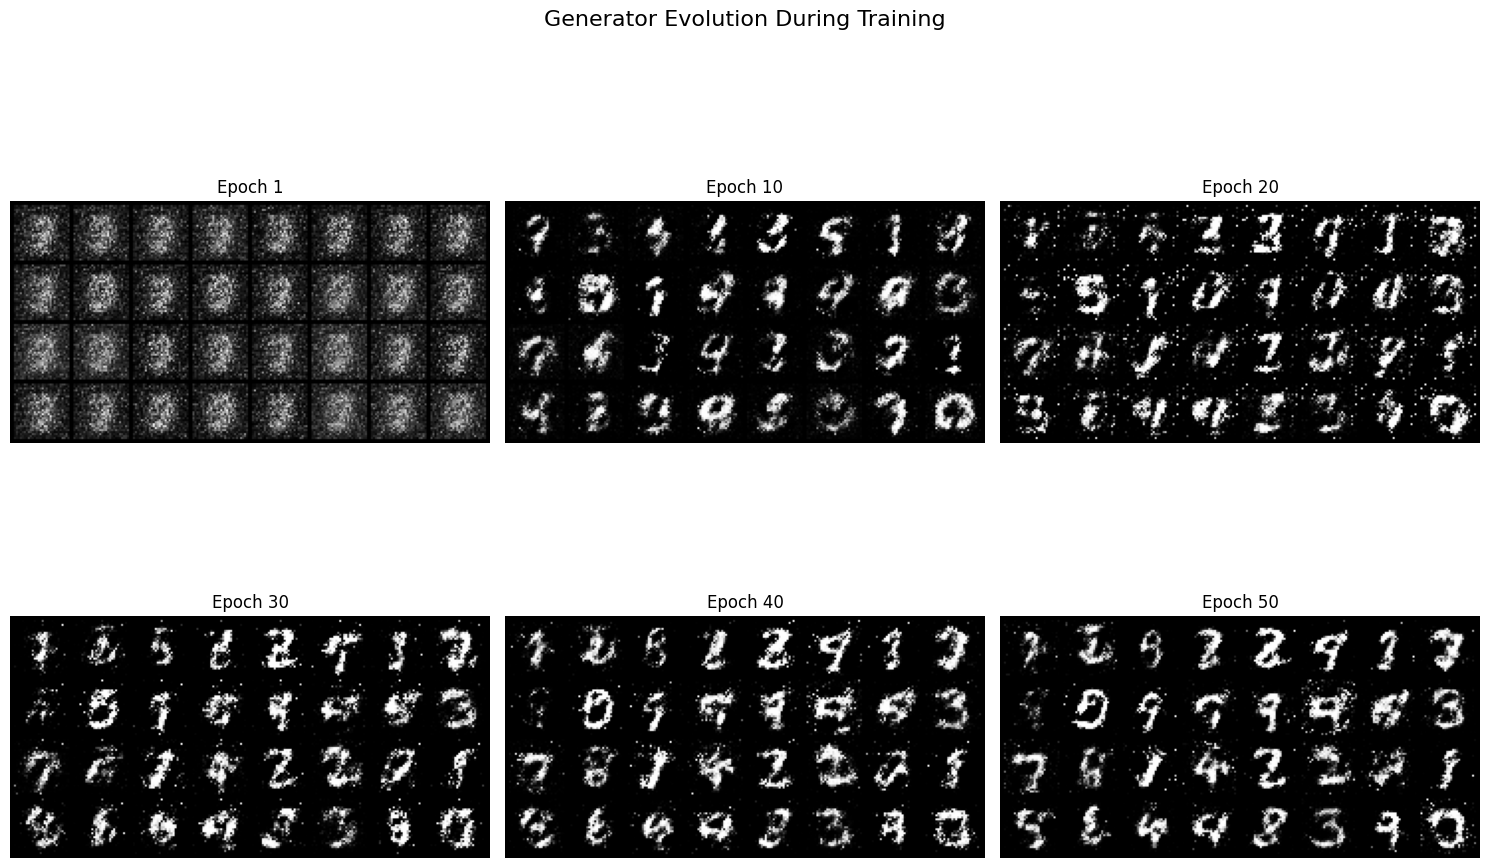

In [13]:
# Visualize generated images at different epochs
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
epochs_to_show = [0, 9, 19, 29, 39, 49]

for idx, epoch in enumerate(epochs_to_show):
    if epoch < len(img_list):
        ax = axes[idx // 3, idx % 3]
        ax.axis("off")
        ax.set_title(f"Epoch {epoch + 1}", fontsize=12)
        ax.imshow(np.transpose(img_list[epoch].cpu(), (1, 2, 0)))

plt.tight_layout()
plt.suptitle("Generator Evolution During Training", fontsize=16, y=1.02)
plt.show()

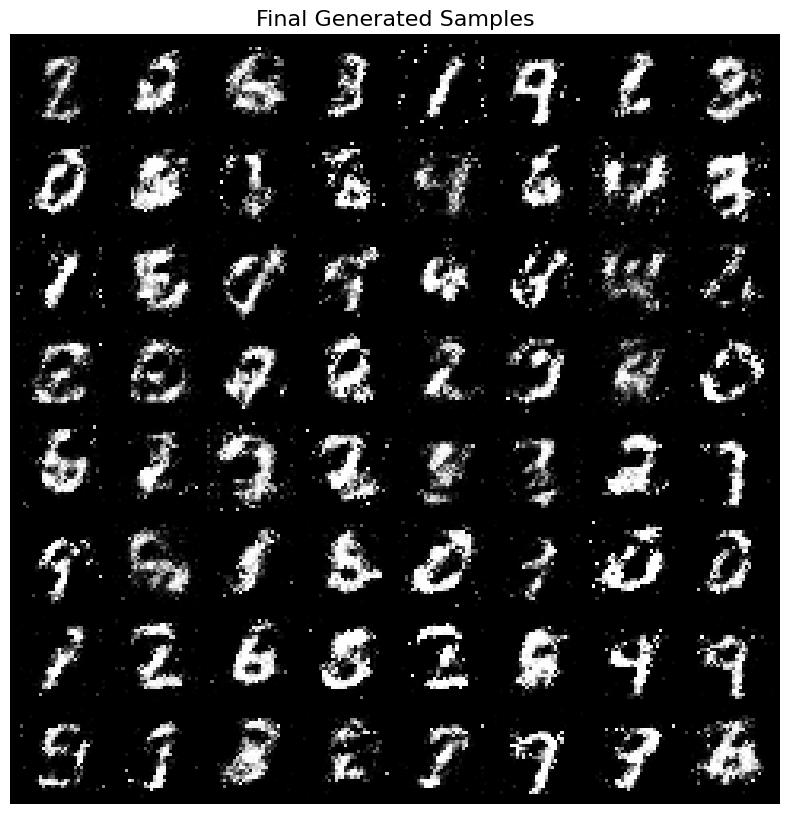


Observations:
- Early epochs: Random noise with vague digit-like shapes
- Middle epochs: Recognizable digits emerge but with artifacts
- Final epochs: Clear, varied handwritten digits


In [14]:
# Generate and display final results
gen.eval()
with torch.no_grad():
    sample_noise = torch.randn(64, z_dim).to(device)
    generated_images = gen(sample_noise).reshape(-1, 1, 28, 28)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Final Generated Samples", fontsize=16)
grid = torchvision.utils.make_grid(generated_images, normalize=True, nrow=8)
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.show()

print("\nObservations:")
print("- Early epochs: Random noise with vague digit-like shapes")
print("- Middle epochs: Recognizable digits emerge but with artifacts")
print("- Final epochs: Clear, varied handwritten digits")

### Conclusion (MLP-GAN)

As you can see, the generator starts with pure noise (Epoch 0) and slowly learns to produce shapes that are recognizably "digit-like". However, the results are very blurry and noisy.

**The Problem:** MLPs (fully-connected layers) are terrible for image data. When we flatten the $28 \times 28$ image into a $784$-pixel vector, we **throw away all spatial information**. The model doesn't know which pixels are next to each other.

To improve, we need a model that understands spatial structure: **Convolutional Neural Networks.**

---

## 4. Deep Convolutional GAN (DCGAN) <a id='dcgan'></a>

### Introduction to DCGAN

**Deep Convolutional GANs (DCGANs)**, introduced by Radford et al. in 2015, brought stability and improved quality to GAN training by using convolutional and transpose-convolutional layers instead of fully connected layers.

### 2.1 Key Ideas of DCGAN

The DCGAN architecture has a few key guidelines:

1.  **No Pooling Layers:**
    * The **Discriminator** uses **strided convolutions** to downsample the image. This allows the network to *learn* its own spatial downsampling, unlike max-pooling which is fixed.
    * The **Generator** uses **transposed convolutions** (also called fractional-strided convolutions or "deconvolutions") to upsample the image. This is the learnable inverse of a convolution.

2.  **Use Batch Normalization:** `BatchNorm2d` is used in both the Generator and Discriminator (except for the Generator's output layer and Discriminator's input layer). This stabilizes training by normalizing the feature maps.

3.  **Use `ReLU` and `LeakyReLU`:**
    * The **Generator** uses `ReLU` activations in all layers except the output, which uses `tanh` (to match our `[-1, 1]` data).
    * The **Discriminator** uses `LeakyReLU` activations in all layers, which helps gradients flow better (just like in our MLP-GAN).

### Why DCGAN Works Better

- **Spatial structure**: Convolutions preserve spatial relationships in images
- **Parameter efficiency**: Fewer parameters than fully connected networks
- **Better gradient flow**: Batch normalization helps stabilize training
- **Hierarchical features**: Network learns features at multiple scales

### 4.1 DCGAN Architecture Implementation

#### DCGAN Discriminator

**Architecture Flow:**
```
Input (1, 28, 28)
    ↓ Conv2d (stride=2) - Downsample
(64, 14, 14)
    ↓ Conv2d (stride=2) - Downsample
(128, 7, 7)
    ↓ Conv2d (stride=2) - Downsample
(256, 4, 4)
    ↓ Conv2d - Final
(1, 1, 1) → Single logit
```

**Key Features:**
- Strided convolutions replace pooling
- Batch normalization after each conv (except first)
- LeakyReLU activations throughout
- Progressively increase feature maps

In [ ]:
class DCGANDiscriminator(nn.Module):
    """DCGAN Discriminator with convolutional layers."""

    def __init__(self, channels_img=1, features_d=64):
        super().__init__()

        self.disc = nn.Sequential(
            # Input: N x channels_img x 28 x 28
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),  # 14x14
            nn.LeakyReLU(0.2),

            # N x features_d x 14 x 14
            self._block(features_d, features_d * 2, 4, 2, 1),  # 7x7

            # N x (features_d*2) x 7 x 7
            self._block(features_d * 2, features_d * 4, 3, 1, 0),  # 5x5

            # N x (features_d*4) x 5 x 5
            self._block(features_d * 4, features_d * 8, 2, 1, 0), # 4x4

            # N x (features_d*8) x 4 x 4
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0),  # 1x1
            # Output: N x 1 x 1 x 1
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        """Convolutional block: Conv -> BatchNorm -> LeakyReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

# Test DCGAN discriminator
test_dcgan_disc = DCGANDiscriminator(channels_img=1, features_d=64)
test_img = torch.randn(32, 1, 28, 28)
test_output = test_dcgan_disc(test_img)
print(f"DCGAN Discriminator:")
print(f"  Input shape: {test_img.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Parameters: {sum(p.numel() for p in test_dcgan_disc.parameters()):,}")

DCGAN Discriminator:
  Input shape: torch.Size([32, 1, 28, 28])
  Output shape: torch.Size([32, 1, 1, 1])
  Parameters: 961,345


#### DCGAN Generator

**Architecture Flow:**
```
Noise vector (100,)
    ↓ Project & Reshape
(256, 4, 4)
    ↓ ConvTranspose2d (stride=2) - Upsample
(128, 7, 7)
    ↓ ConvTranspose2d (stride=2) - Upsample
(64, 14, 14)
    ↓ ConvTranspose2d (stride=2) - Upsample
(1, 28, 28) → Generated image
```

**Key Features:**
- Transpose convolutions for upsampling
- Batch normalization after each layer (except output)
- ReLU activations (except final Tanh)
- Progressively decrease feature maps

In [ ]:
class DCGANGenerator(nn.Module):
    """DCGAN Generator with transpose convolutional layers."""

    def __init__(self, z_dim=100, channels_img=1, features_g=64):
        super().__init__()

        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g * 4, 4, 1, 0),  # 4x4

            # N x (features_g*4) x 4 x 4
            self._block(features_g * 4, features_g * 2, 3, 2, 1),  # 7x7

            # N x (features_g*2) x 7 x 7
            self._block(features_g * 2, features_g, 4, 2, 1),  # 14x14

            # N x features_g x 14 x 14
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),  # 28x28
            nn.Tanh(),  # Output range: [-1, 1]
            # Output: N x channels_img x 28 x 28
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        """Transpose convolutional block: ConvTranspose -> BatchNorm -> ReLU"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

# Test DCGAN generator
test_dcgan_gen = DCGANGenerator(z_dim=100, channels_img=1, features_g=64)
test_noise = torch.randn(32, 100, 1, 1)
test_fake = test_dcgan_gen(test_noise)
print(f"\nDCGAN Generator:")
print(f"  Input shape: {test_noise.shape}")
print(f"  Output shape: {test_fake.shape}")
print(f"  Output range: [{test_fake.min():.2f}, {test_fake.max():.2f}]")
print(f"  Parameters: {sum(p.numel() for p in test_dcgan_gen.parameters()):,}")


DCGAN Generator:
  Input shape: torch.Size([32, 100, 1, 1])
  Output shape: torch.Size([32, 1, 28, 28])
  Output range: [-1.00, 1.00]
  Parameters: 837,505


### 4.2 Weight Initialization

Proper weight initialization is crucial for DCGAN training. The original paper recommends:
- Initialize weights from a Normal distribution with mean=0, std=0.02
- This helps training converge faster and more stably

In [25]:
def initialize_weights(model):
    """Initialize network weights according to DCGAN paper."""
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

print("Weight initialization function defined.")

Weight initialization function defined.


### 4.3 Training DCGAN

The training procedure is similar to vanilla GAN, but we work with 2D images instead of flattened vectors.

In [26]:
# Hyperparameters for DCGAN
lr_dcgan = 2e-4
batch_size_dcgan = 128
z_dim_dcgan = 100
num_epochs_dcgan = 50
features_d = 64
features_g = 64

# Initialize DCGAN networks
dcgan_disc = DCGANDiscriminator(channels_img=1, features_d=features_d).to(device)
dcgan_gen = DCGANGenerator(z_dim=z_dim_dcgan, channels_img=1, features_g=features_g).to(device)

# Apply weight initialization
initialize_weights(dcgan_disc)
initialize_weights(dcgan_gen)

# Fixed noise for visualization
fixed_noise_dcgan = torch.randn(batch_size_dcgan, z_dim_dcgan, 1, 1).to(device)

# Optimizers
opt_disc_dcgan = optim.Adam(dcgan_disc.parameters(), lr=lr_dcgan, betas=(0.5, 0.999))
opt_gen_dcgan = optim.Adam(dcgan_gen.parameters(), lr=lr_dcgan, betas=(0.5, 0.999))

# Loss function
criterion_dcgan = nn.BCEWithLogitsLoss()

print("DCGAN initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in dcgan_gen.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in dcgan_disc.parameters()):,}")

DCGAN initialized successfully!
Generator parameters: 837,505
Discriminator parameters: 961,345


In [27]:
# Training loop for DCGAN
dcgan_gen_losses = []
dcgan_disc_losses = []
dcgan_img_list = []

print("Starting DCGAN Training...\n" + "="*50)

for epoch in range(num_epochs_dcgan):
    epoch_g_loss = 0
    epoch_d_loss = 0

    for batch_idx, (real, _) in enumerate(loader):
        # Move images to device (keep 2D structure)
        real = real.to(device)
        batch_size_current = real.shape[0]

        # ===========================
        # Train Discriminator
        # ===========================

        dcgan_disc.zero_grad()

        # Train on real images
        disc_real = dcgan_disc(real).view(-1)
        lossD_real = criterion_dcgan(disc_real, torch.ones_like(disc_real))

        # Train on fake images
        noise = torch.randn(batch_size_current, z_dim_dcgan, 1, 1).to(device)
        fake = dcgan_gen(noise)
        disc_fake = dcgan_disc(fake.detach()).view(-1)
        lossD_fake = criterion_dcgan(disc_fake, torch.zeros_like(disc_fake))

        # Combine and update
        lossD = (lossD_real + lossD_fake) / 2
        lossD.backward()
        opt_disc_dcgan.step()

        # ===========================
        # Train Generator
        # ===========================

        dcgan_gen.zero_grad()

        output = dcgan_disc(fake).view(-1)
        lossG = criterion_dcgan(output, torch.ones_like(output))
        lossG.backward()
        opt_gen_dcgan.step()

        # Accumulate losses
        epoch_g_loss += lossG.item()
        epoch_d_loss += lossD.item()

        # Print progress
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs_dcgan}] Batch [{batch_idx}/{len(loader)}] "
                  f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

    # Store average epoch losses
    avg_g_loss = epoch_g_loss / len(loader)
    avg_d_loss = epoch_d_loss / len(loader)
    dcgan_gen_losses.append(avg_g_loss)
    dcgan_disc_losses.append(avg_d_loss)

    # Generate samples for visualization
    with torch.no_grad():
        fake_images = dcgan_gen(fixed_noise_dcgan)
        img_grid = torchvision.utils.make_grid(fake_images[:32], normalize=True, nrow=8)
        dcgan_img_list.append(img_grid)

    print(f"\nEpoch [{epoch+1}/{num_epochs_dcgan}] completed - Avg Loss D: {avg_d_loss:.4f}, Avg Loss G: {avg_g_loss:.4f}\n")

print("="*50)
print("DCGAN Training completed!")

Starting DCGAN Training...
Epoch [1/50] Batch [0/469] Loss D: 0.6869, Loss G: 0.7775
Epoch [1/50] Batch [100/469] Loss D: 0.0158, Loss G: 4.1540
Epoch [1/50] Batch [200/469] Loss D: 0.0040, Loss G: 5.4806
Epoch [1/50] Batch [300/469] Loss D: 1.5395, Loss G: 2.3164
Epoch [1/50] Batch [400/469] Loss D: 0.1269, Loss G: 2.4563

Epoch [1/50] completed - Avg Loss D: 0.2119, Avg Loss G: 3.1784

Epoch [2/50] Batch [0/469] Loss D: 1.1954, Loss G: 2.4106
Epoch [2/50] Batch [100/469] Loss D: 0.8650, Loss G: 3.6669
Epoch [2/50] Batch [200/469] Loss D: 0.4230, Loss G: 2.7830
Epoch [2/50] Batch [300/469] Loss D: 0.3488, Loss G: 1.9910
Epoch [2/50] Batch [400/469] Loss D: 0.4468, Loss G: 2.9075

Epoch [2/50] completed - Avg Loss D: 0.3628, Avg Loss G: 1.9508

Epoch [3/50] Batch [0/469] Loss D: 0.2699, Loss G: 2.3012
Epoch [3/50] Batch [100/469] Loss D: 0.2329, Loss G: 1.4793
Epoch [3/50] Batch [200/469] Loss D: 0.4032, Loss G: 1.5625
Epoch [3/50] Batch [300/469] Loss D: 0.2088, Loss G: 2.3752
Epoch [

### 4.4 DCGAN Results and Comparison

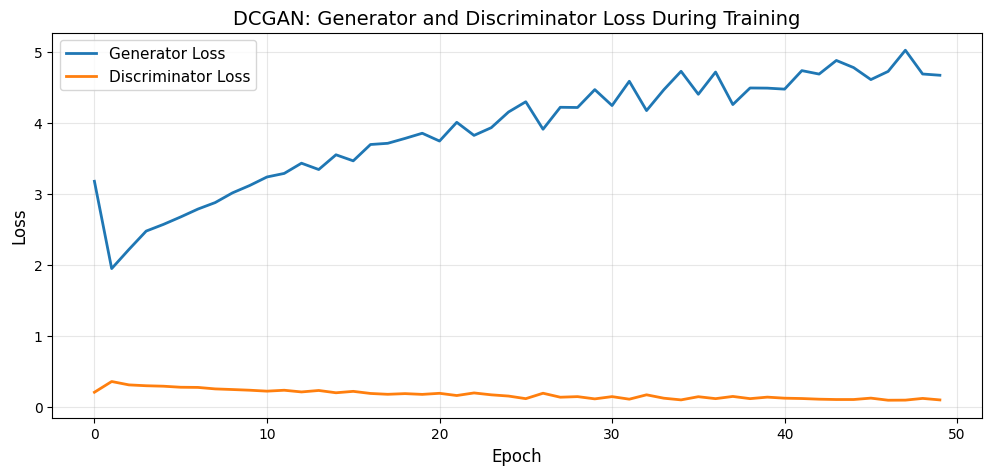


DCGAN Loss Analysis:
Final Generator Loss: 4.6695
Final Discriminator Loss: 0.1041


In [28]:
# Plot DCGAN training losses
plt.figure(figsize=(12, 5))
plt.title("DCGAN: Generator and Discriminator Loss During Training", fontsize=14)
plt.plot(dcgan_gen_losses, label="Generator Loss", linewidth=2)
plt.plot(dcgan_disc_losses, label="Discriminator Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("\nDCGAN Loss Analysis:")
print(f"Final Generator Loss: {dcgan_gen_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {dcgan_disc_losses[-1]:.4f}")

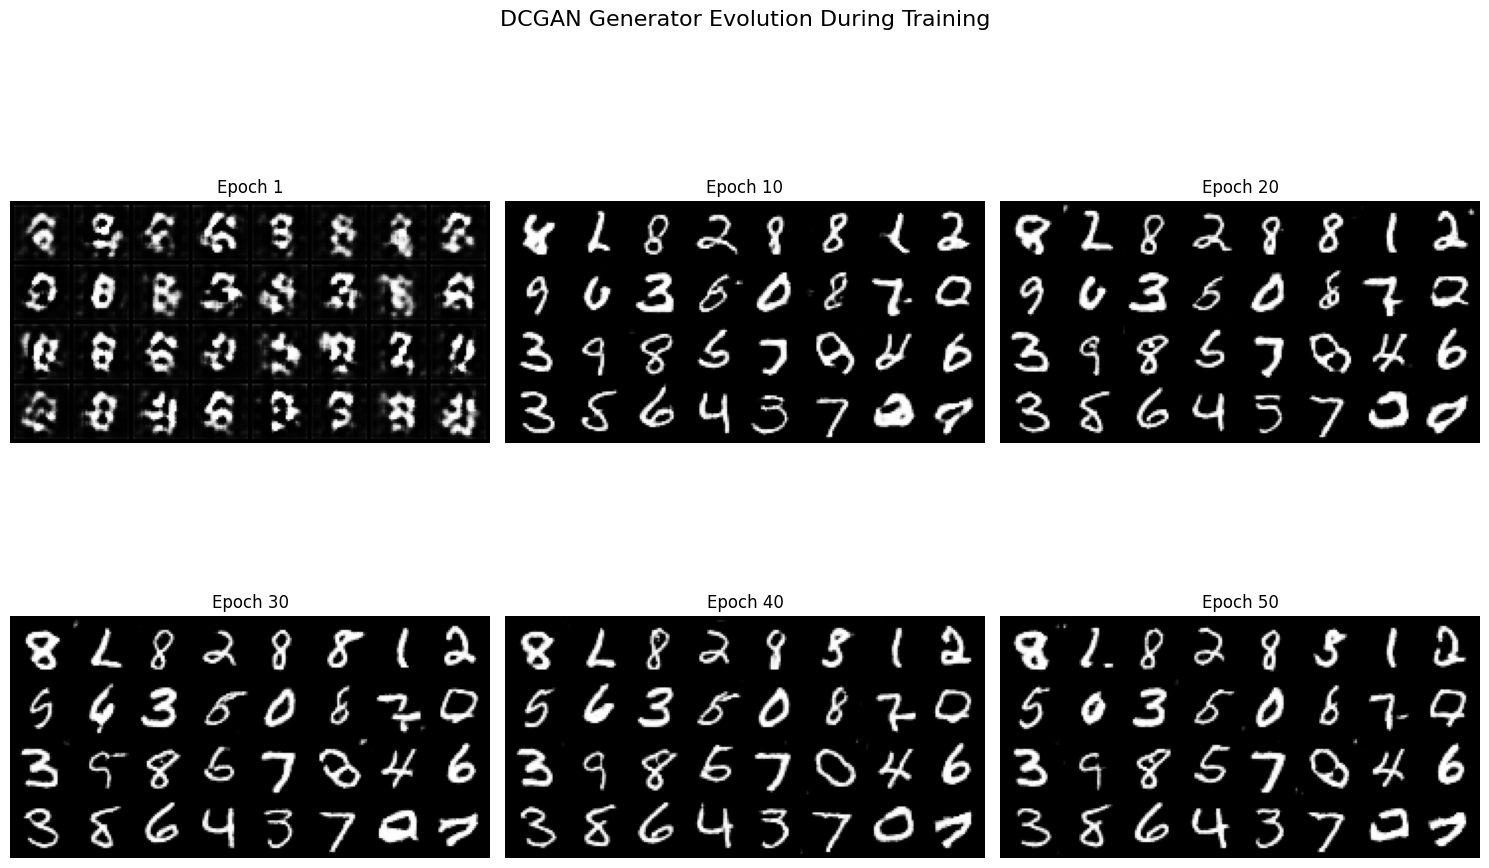

In [29]:
# Visualize DCGAN progression
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
epochs_to_show = [0, 9, 19, 29, 39, 49]

for idx, epoch in enumerate(epochs_to_show):
    if epoch < len(dcgan_img_list):
        ax = axes[idx // 3, idx % 3]
        ax.axis("off")
        ax.set_title(f"Epoch {epoch + 1}", fontsize=12)
        ax.imshow(np.transpose(dcgan_img_list[epoch].cpu(), (1, 2, 0)))

plt.tight_layout()
plt.suptitle("DCGAN Generator Evolution During Training", fontsize=16, y=1.02)
plt.show()

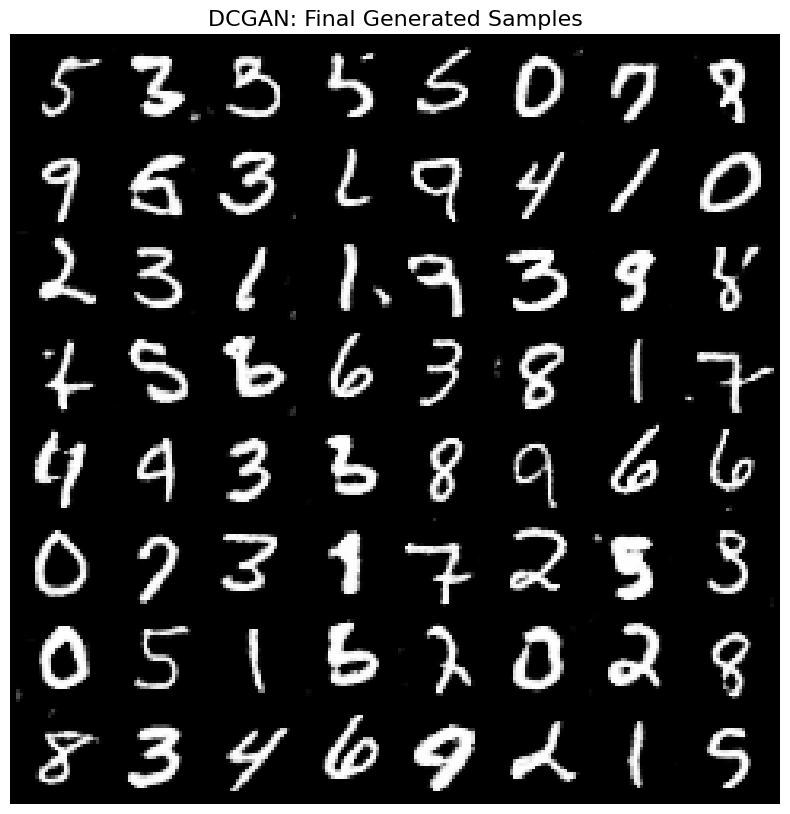

In [30]:
# Generate final DCGAN samples
dcgan_gen.eval()
with torch.no_grad():
    sample_noise = torch.randn(64, z_dim_dcgan, 1, 1).to(device)
    dcgan_generated = dcgan_gen(sample_noise)

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("DCGAN: Final Generated Samples", fontsize=16)
grid = torchvision.utils.make_grid(dcgan_generated, normalize=True, nrow=8)
plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
plt.show()

### 4.5 Side-by-Side Comparison: Vanilla GAN vs DCGAN

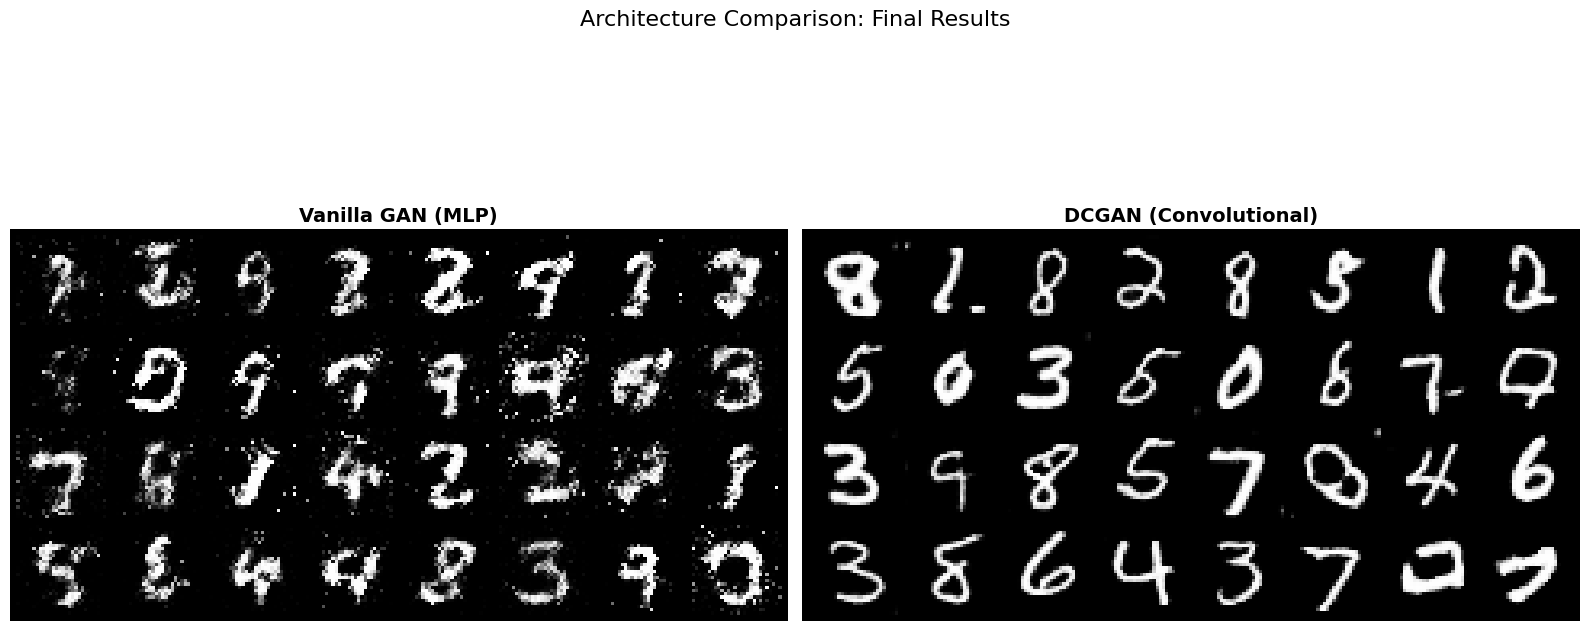


COMPARISON ANALYSIS

Vanilla GAN (MLP):
  ✓ Simpler architecture
  ✓ Fewer parameters
  ✗ Less detailed images
  ✗ More artifacts and blur

DCGAN (Convolutional):
  ✓ Sharper, more realistic images
  ✓ Better spatial structure
  ✓ More stable training
  ✗ More complex architecture
  ✗ More parameters to tune


In [31]:
# Compare final outputs
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Vanilla GAN
axes[0].axis("off")
axes[0].set_title("Vanilla GAN (MLP)", fontsize=14, fontweight='bold')
if len(img_list) > 0:
    axes[0].imshow(np.transpose(img_list[-1].cpu(), (1, 2, 0)))

# DCGAN
axes[1].axis("off")
axes[1].set_title("DCGAN (Convolutional)", fontsize=14, fontweight='bold')
if len(dcgan_img_list) > 0:
    axes[1].imshow(np.transpose(dcgan_img_list[-1].cpu(), (1, 2, 0)))

plt.tight_layout()
plt.suptitle("Architecture Comparison: Final Results", fontsize=16, y=1.02)
plt.show()

print("\n" + "="*60)
print("COMPARISON ANALYSIS")
print("="*60)
print("\nVanilla GAN (MLP):")
print("  ✓ Simpler architecture")
print("  ✓ Fewer parameters")
print("  ✗ Less detailed images")
print("  ✗ More artifacts and blur")
print("\nDCGAN (Convolutional):")
print("  ✓ Sharper, more realistic images")
print("  ✓ Better spatial structure")
print("  ✓ More stable training")
print("  ✗ More complex architecture")
print("  ✗ More parameters to tune")

## Overall Conclusion

Congratulations! You've built two different GANs from scratch.

By comparing the results, the difference is night and day. The **MLP-GAN** produced blurry, noisy shapes that only vaguely resembled digits. This is because it could not understand spatial relationships.

The **DCGAN**, by using convolutions and transpose convolutions, learned the spatial structure of the images. Its results are dramatically sharper, more coherent, and clearly recognizable as digits. This demonstrates why convolutional architectures are essential for image-based tasks.

### Key Takeaways:
- **GANs are a game** between a Generator (forger) and a Discriminator (critic).
- **The loss function is adversarial:** The Generator is trained to fool the Discriminator by labeling fake images as *real*.
- **Architecture matters:** Replacing MLPs with a **DCGAN** (strided convolutions, transpose convolutions, and batch norm) yields a massive improvement in image quality by preserving spatial information.